In [10]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figsize=(15, 10)
export_dir = './plots/'
data_dir = '/home/yuxin/ray_results/PPO/PPO_meltingpot_'
env_list = ['Chicken_5M','Prisoners_Dilemma_5M','Pure_Coordination_5M','Stag_Hunt_5M']
total_timestep = 6e6

sns.set()
sns.set_context("talk")

In [2]:
def get_section_results(file, env_name, *tags):
    data_dict = {'env_step': [], 'env_name': []}
    data_dict.update({tag: [] for tag in tags})
    max_step = -1
    for e in tf.compat.v1.train.summary_iterator(file):
        prev_step = -1
        for v in e.summary.value:
            if v.tag in data_dict:
                data_dict[v.tag].append(v.simple_value)
                if prev_step != e.step:
                    prev_step = e.step
                    if max_step < e.step:
                        max_step = e.step
                        data_dict['env_step'].append(e.step)
                        data_dict['env_name'].append(env_name)
    data_dict = {tag: np.array(data_dict[tag]) for tag in data_dict}
    return data_dict

In [3]:
def read_evaluation_data(env_list, size, smooth_alpha):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for env in env_list:
        logdir = os.path.join(data_dir+env, 'events*')
        print(logdir)
        eventfile = glob.glob(logdir)[0]
        data_dict = get_section_results(eventfile, env, 'ray/tune/episode_reward_min',
                                        'ray/tune/episode_reward_mean','ray/tune/episode_reward_max')
        data = pd.DataFrame(data_dict)
        for (columnName, columnData) in data.items():
            if columnName != 'env_step' and columnName != 'env_name':
                data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=smooth_alpha).mean()

        # reduce size for plotting
        count_row = data.shape[0]
        reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
        data_p = data.iloc[reduced_row]

        full_data = pd.concat([full_data, data], axis=0)
        plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

In [4]:
data, data_plot = read_evaluation_data(env_list, 500, 0.2)

/home/yuxin/ray_results/PPO/PPO_meltingpot_Chicken_5M/events*
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
/home/yuxin/ray_results/PPO/PPO_meltingpot_Prisoners_Dilemma_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Pure_Coordination_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Stag_Hunt_5M/events*


In [5]:
data_plot

,env_step,env_name,ray/tune/episode_reward_min,ray/tune/episode_reward_mean,ray/tune/episode_reward_max,ray/tune/episode_reward_min_smooth,ray/tune/episode_reward_mean_smooth,ray/tune/episode_reward_max_smooth
0,3200,Chicken_5M,25.602705,25.602705,25.602705,25.602705,25.602705,25.602705
6,12800,Chicken_5M,16.327444,34.535484,64.640694,17.711950,31.693962,54.766911
12,22400,Chicken_5M,9.309524,36.656296,79.537766,12.246540,37.182578,74.107494
18,32000,Chicken_5M,9.309524,37.211838,79.537766,10.047757,37.160693,78.172840
25,43200,Chicken_5M,9.309524,39.986023,79.537766,9.462574,38.577853,79.254790
...,...,...,...,...,...,...,...,...
3097,4958400,Stag_Hunt_5M,51.116295,104.494461,169.156357,50.735736,104.652782,169.155686
3104,4969600,Stag_Hunt_5M,51.116295,104.674194,169.156357,51.036486,104.804245,169.156216
3110,4979200,Stag_Hunt_5M,51.116295,105.655174,169.156357,51.095373,105.199264,169.156320
3116,4988800,Stag_Hunt_5M,51.787663,105.239143,169.156357,51.562184,105.362850,169.156347


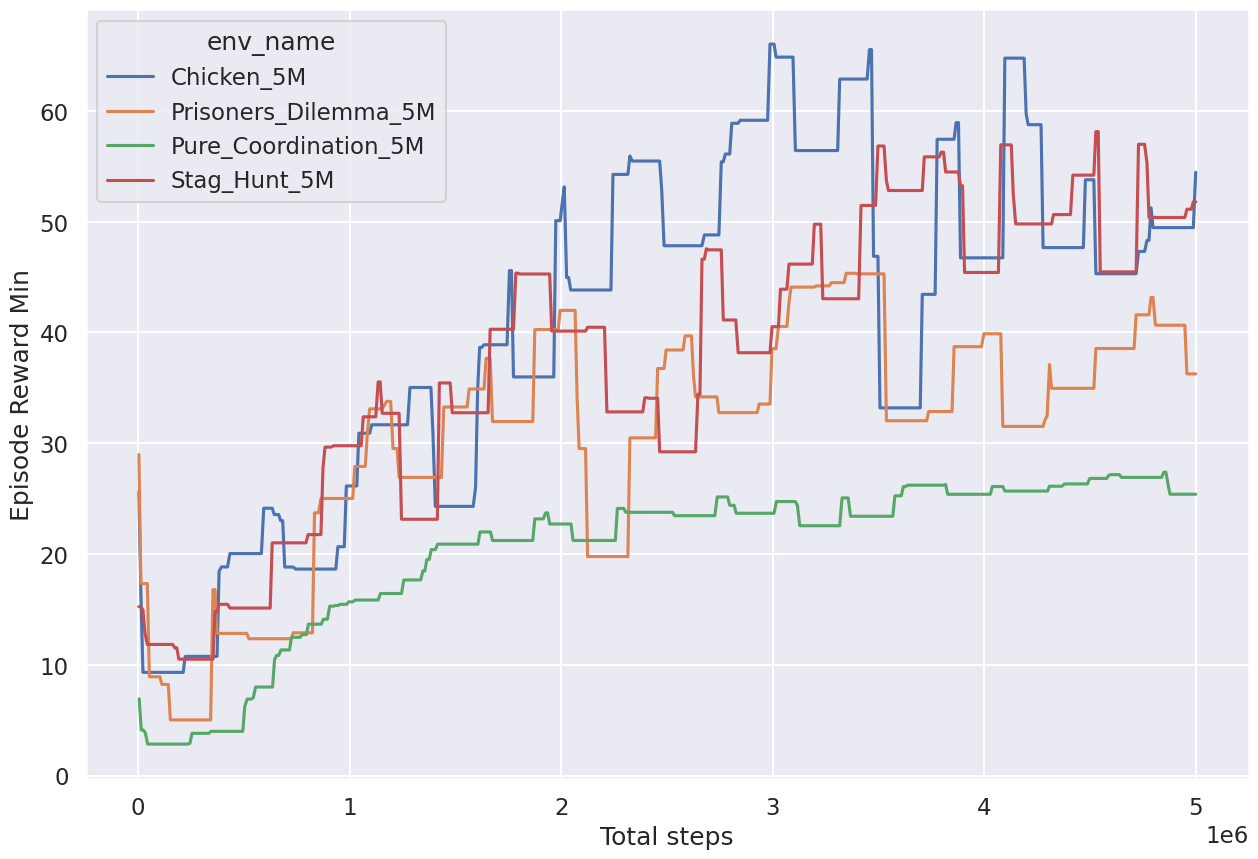

In [7]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_min', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Min')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'ep_rew_min.pdf'), bbox_inches='tight')

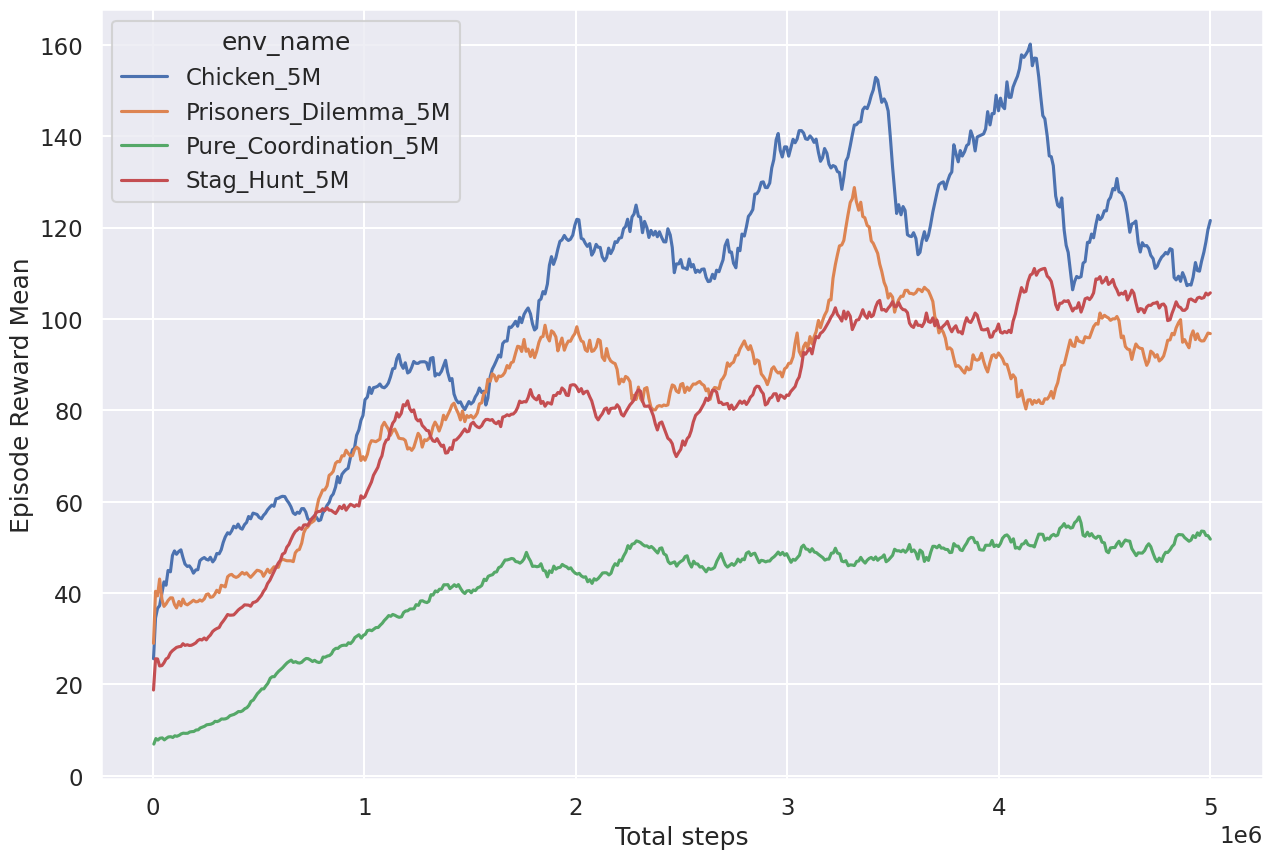

In [8]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_mean', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Mean')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'ep_rew_mean.pdf'), bbox_inches='tight')

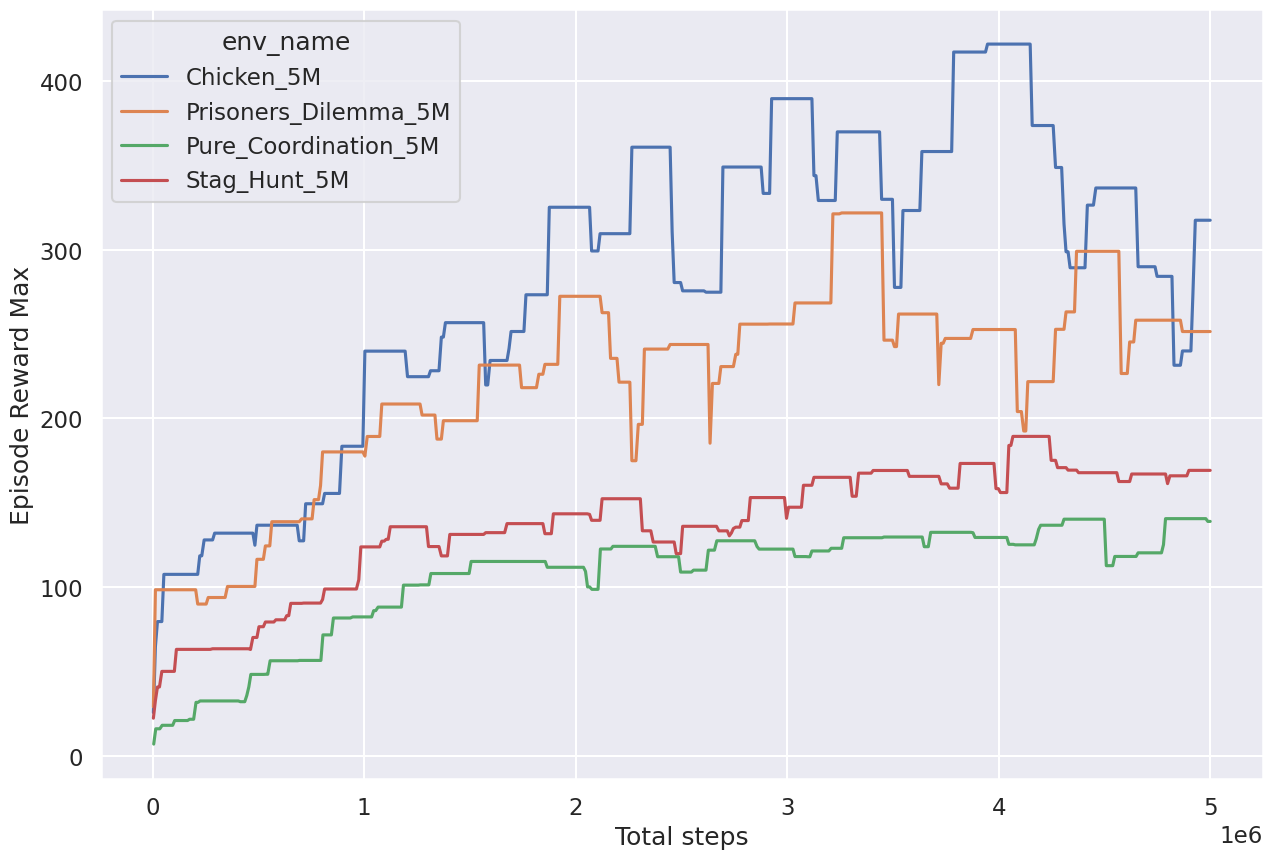

In [9]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_max', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Max')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'ep_rew_max.pdf'), bbox_inches='tight')